Batch Dilate and Erode Masked Nuclei

Aim : To load, threshold, and detect nuceli for futher analysis.

Updates for v4.2

- forget opencv
- targeted file list
- slow but cleaner shell detection
- automate file naming to avoid errors
- no plots
- run as a for loop

still to do

- prevent overwriting files

In [105]:
##Import modules etc.
import glob
import os
import time
import pandas as pd
import numpy as np
import mahotas as mh
import seaborn as sns
from skimage.measure import regionprops

#from skimage.morphology import 
from mahotas.labeled import filter_labeled
from scipy.ndimage import morphology
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#[1] Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/'

target='_Mask5.npy'

filelist=glob.glob(path+str('*')+target)

In [3]:
#Specify output directory
output='Shells/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [4]:
filelist[3]

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_1_Mask5.npy'

In [5]:
Mask5=np.load(filelist[3])

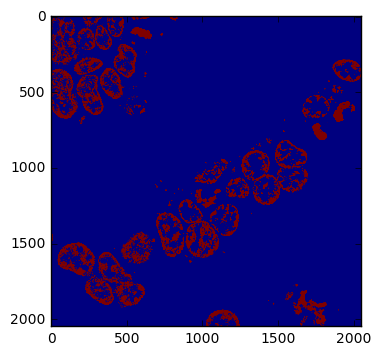

In [6]:
plt.imshow(Mask5[4])

**Define Functions**

In [20]:
def labelNuceli(mask, min_vol = 8000):
#By default min_vol = 8000
    from skimage import morphology

    labeled_mask, nr_objects=mh.label(mask)
    #print('{} objects were detected.'.format(nr_objects))
    
    real=morphology.remove_small_objects(labeled_mask, min_vol)
    
    #Reset counts  and count the labels, 
    relabeled, n_left = mh.labeled.relabel(real)
    #print('After filtering and relabeling, there are {} nuclei left.'.format(n_left))

    return relabeled

In [21]:
relabeled = labelNuceli(Mask5, min_vol = 8000)

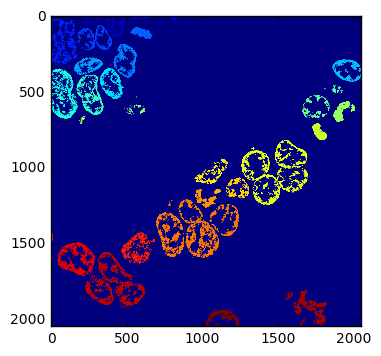

In [45]:
plt.imshow(relabeled[4])

In [38]:
sizes = mh.labeled.labeled_size(relabeled)

In [47]:
np.sort(sizes)

array([    8242,     9018,    12675,    15807,    23032,    23146,
          30710,    57531,    60523,    86918,   118482,   119286,
         129061,   129911,   133828,   164095,   190209,   200936,
         212163,   215257,   228940,   247840,   268093,   279041,
         368614,   418057,   457973,   464086,   477783,   509031,
         871841,  1127597,  1363077, 91640493], dtype=uint32)

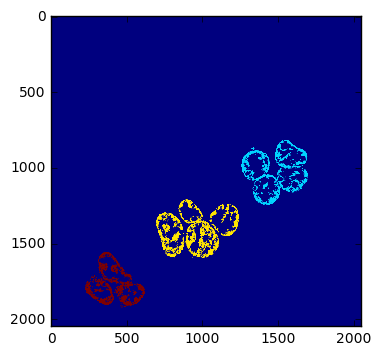

In [52]:
big, n_big=mh.labeled.filter_labeled(relabeled, min_size=750000)
plt.imshow(big[4])

In [28]:
def dilateFillErode(stack):

    #Let's do every z slice
    final_stack=np.zeros_like(stack)
    
    for z, frame in enumerate(stack):

        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            blob=morphology.binary_dilation(frame==ll, np.ones((20,20)))
            filled_blob=morphology.binary_fill_holes(blob)
            reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))*ll
            final=final+reduced

        final_stack[z]=final
    
    return final_stack

In [29]:
##Time function
t0 = time.time() #remember the brackets
Mask7 = dilateFillErode(relabeled)
t1 = time.time() #remember the brackets
dt=t1-t0
print (dt)

1453.00200009


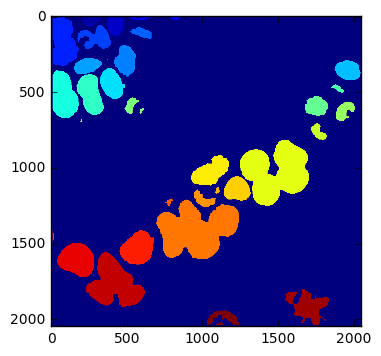

In [59]:
plt.imshow(Mask7[10])

In [55]:
sizes = mh.labeled.labeled_size(Mask7)

In [56]:
np.sort(sizes)

array([       0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        8,     7232,    10299,    14031,
          19480,    25893,    26224,    47243,    54911,   105552,
         125431,   137998,   141412,   142255,   180398,   248877,
         297127,   315852,   346057,   359213,   471575,   478615,
         492208,   506665,   659138,   702618,   717441,   846311,
         918528,   921840,   997328,  1724155,  2854315,  3092694, 82674372], dtype=uint32)

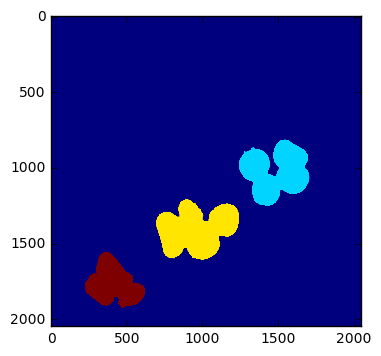

In [62]:
big, n_big=mh.labeled.filter_labeled(Mask7, min_size=1000000)
plt.imshow(big.max(axis=0))

In [156]:
##Calculate 3D distance transform
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

# Calculate distance transform of labeled image
distance = ndimage.distance_transform_edt(big)

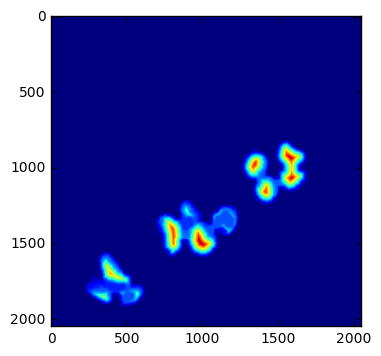

In [157]:
plt.imshow(distance[4])

(<matplotlib.axes._subplots.AxesSubplot at 0x86e4da90>,
 <matplotlib.text.Text at 0x373b8898>)

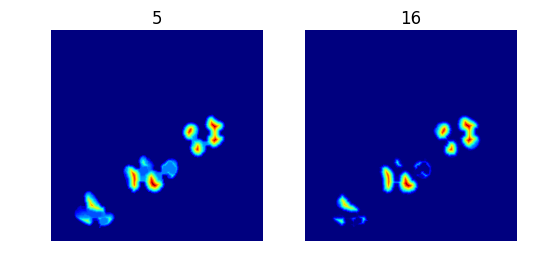

In [67]:
#Check results
plt.subplot(1,2,1),plt.imshow(distance[0])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('5')
plt.subplot(1,2,2),plt.imshow(distance[20])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('16')

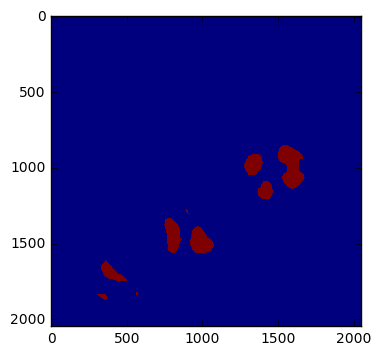

In [79]:
dt=distance>25
plt.imshow(dt[22])

In [100]:
local_max10 = peak_local_max(distance, indices=False, threshold_abs=5, footprint=np.ones((1, 150, 150)), labels=big)

In [107]:
collect=morphology.binary_dilation(local_max10.max(axis=0), np.ones((15,15)))

In [ ]:
collect3D = np.repeat(collect[np.newaxis, :, :], 24, axis=0)

In [ ]:
##Count collections
collections, n_collections=mh.label(collect3D)
n_collections

In [96]:
##if the footprint is the full z-width, no peaks are detected
#local_max10 = peak_local_max(distance, indices=False, threshold_abs=5, footprint=np.ones((24, 150, 150)), labels=big)

In [147]:
z=5

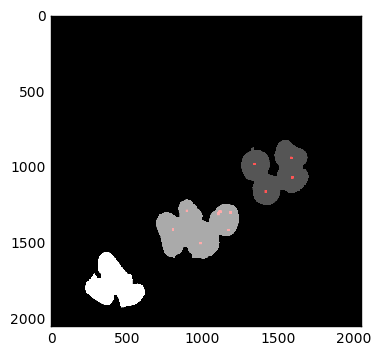

In [118]:
##Check local max using overlay
plt.imshow(mh.overlay(big[z], collect3D[z]))

(<matplotlib.axes._subplots.AxesSubplot at 0x6622e630>,
 <matplotlib.text.Text at 0x66185ac8>)

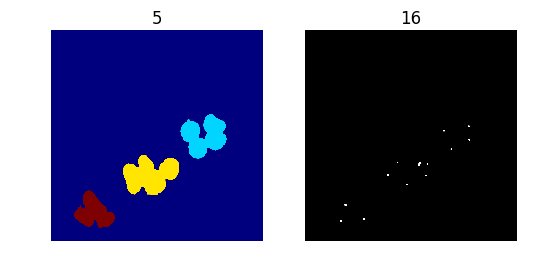

In [119]:
#Check results
plt.subplot(1,2,1),plt.imshow(big[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('5')
plt.subplot(1,2,2),plt.imshow(collect3D[z], cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('16')

In [93]:
##Count markers
markers, n_markers=mh.label(local_max10)
n_markers

77L

In [123]:
##Cluster in z
marker_props = regionprops(markers, collections) #Use filled mask as intensity image to preserve original labeling

m_head=['Marker','x','y','z','Collection']
m_props=[]

for m in marker_props:
    
    #Get bounding box
    bb=np.array(m.bbox)
    #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox

    #Calculate Center
    zcent=int(round((bb[0]+bb[3])/2))
    ycent=int(round((bb[1]+bb[4])/2))
    xcent=int(round((bb[2]+bb[5])/2))
    
    
    m_props.append([int(m.label),
                      xcent,
                      ycent,
                      zcent,
                      m.mean_intensity])
    
Marker_Properties = pd.DataFrame(m_props, columns=m_head)

In [138]:
#Average markers if they are within the same collection
center_positions = Marker_Properties.groupby('Collection', as_index=False)['x','y','z'].mean().astype(int)

In [ ]:
#Make 3D binary
centers=np.zeros_like(Mask7)

#Specify True values based on coodinate list
centers[center_positions['z'], center_positions['y'], center_positions['x']] = center_positions['Collection']

#Visual Check
#plt.imshow(morphology.binary_dilation(centers.max(axis=0), np.ones((15,15))))

In [144]:
##3D watershed with unique centers
split = watershed(image = -distance, markers = centers, mask=big)

(<matplotlib.axes._subplots.AxesSubplot at 0x66431cc0>,
 <matplotlib.text.Text at 0x86535438>)

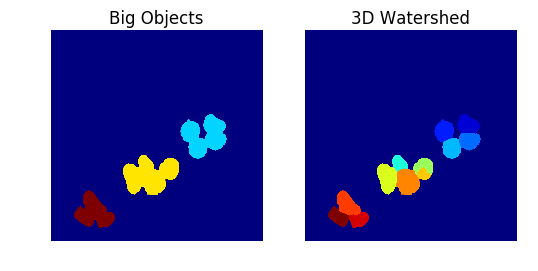

In [148]:
#Check results
plt.subplot(1,2,1),plt.imshow(big[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Big Objects')
plt.subplot(1,2,2),plt.imshow(split[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('3D Watershed')

In [151]:
#Recombine split objects with original
#Can you just add and relabel?
mask8, n_split = mh.labeled.relabel(Mask7+split)
n_split
#plt.imshow(mask8[z])

36L

**Now deal with the smaller regions**

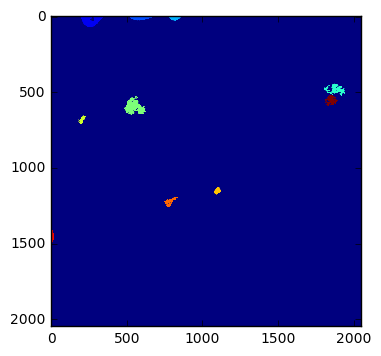

In [153]:
small, n_small=mh.labeled.filter_labeled(relabeled, max_size=100000)
plt.imshow(small.max(axis=0))

(<matplotlib.axes._subplots.AxesSubplot at 0x3559c6d8>,
 <matplotlib.text.Text at 0x35750208>)

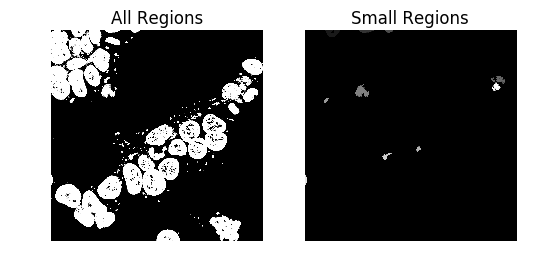

In [155]:
#Check results
plt.subplot(1,2,1),plt.imshow(Mask5.max(axis=0), cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('All Regions')
plt.subplot(1,2,2),plt.imshow(small.max(axis=0), cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Small Regions')

In [31]:
# def dilateFillErode3D(stack):
    
#     final=np.zeros_like(stack)
    
#     for l in range(stack.max()):
#         ll=l+1
#         blob=morphology.binary_dilation(stack==ll, np.ones((3,20,20)))
#         filled_blob=morphology.binary_fill_holes(blob) #This must be done frame by frame
#         reduced=morphology.binary_erosion(filled_blob, np.ones((3,20,20)))*ll
#         final=final+reduced
        
#     return final

In [34]:
def dilateFillErode3D(stack):
    
    final_stack=np.zeros_like(stack)
      
    for l in range(stack.max()):
        ll=l+1
        blob=morphology.binary_dilation(stack==ll, np.ones((3,20,20)))
        final=np.zeros_like(blob)
        for z, frame in enumerate(blob):
            final[z]=morphology.binary_fill_holes(blob[z]) #This must be done frame by frame
        reduced=morphology.binary_erosion(final, np.ones((3,20,20)))*ll
        final_stack=final_stack+reduced
        
    return final_stack

In [35]:
##Time function
t0 = time.time() #remember the brackets
Mask6 = dilateFillErode3D(relabeled)
t1 = time.time() #remember the brackets
dt=t1-t0
print (dt)

3670.38599992


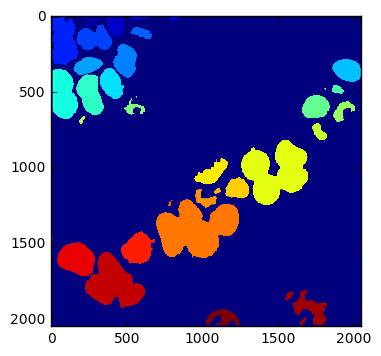

In [36]:
plt.imshow(Mask6[4])

In [33]:
##Define the Object Hulls (~20minutes) 
def hull_3D(labeled_mask):

    filled_mask=np.zeros_like(labeled_mask)
    
    #Iterate through z-slices
    for z, frame in enumerate(labeled_mask):
        #print(z)
        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            
            try:
                hull = convex_hull_image(frame==ll)*ll
            
            except ValueError:
                hull = np.zeros_like(frame)
            
            final = final + hull

        #filled_mask[z]=final #select line to keep objects on the border
        filled_mask[z], n_hulls = filter_labeled(final, remove_bordering=True)
    return filled_mask

In [34]:
def batchConvHull(filelist):

    ##Loop through each mask and generate labeled convex hulls
    for ff, ffile in enumerate(filelist):
        print ff

        #Get filename
        maskfilename = os.path.basename(filelist[ff])
        #Generate filename for Labeled Convex Hulls
        ConvHullsfilename = maskfilename.replace(target, '_ConvHulls.npy')
        #Generate path for Labeled Convex Hulls
        ConvHullspath = newpath+ConvHullsfilename

        ##Import mask
        mask5 = np.load(filelist[ff])

        #Relabel nuclei
        relabeled = labelNuceli(mask5)

        #Generate labeled convex hulls from 3D stack
        hulls = hull_3D(relabeled)
        
        #Relabel hulls because hulls in different frames may have different numbering
        relabeled = labelNuceli(hulls)

        #Save convex hulls
        np.save(ConvHullspath, relabeled)

In [44]:
[filelist[0],filelist[2]]
#filelist[5:7]

['C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output\\Well02_HeLa_PHD2-IDR-PHD3_1_Mask5.npy',
 'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output\\Well02_HeLa_PHD2-IDR-PHD3_3_Mask5.npy']

In [46]:
##Time conversion. ~40minutes for 3 3D masks.
t0 = time.time() #remember the brackets
batchConvHull([filelist[0],filelist[2]])
t1 = time.time() #remember the brackets
dt=t1-t0
print (dt)

0
1
1774.921


### END

Trouble shoot Errors below this cell